[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)

# Generative Adversarial Networks

In this notebook, we play with the GAN described in the lesson on a double moon dataset.

Then we implement a Conditional GAN and an InfoGAN.

In [1]:
# all of these libraries are used for plotting
import numpy as np
import matplotlib.pyplot as plt

# Plot the dataset
def plot_data(ax, X, Y, color = 'bone'):
    plt.axis('off')
    ax.scatter(X[:, 0], X[:, 1], s=1, c=Y, cmap=color)

In [2]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=2000, noise=0.05)

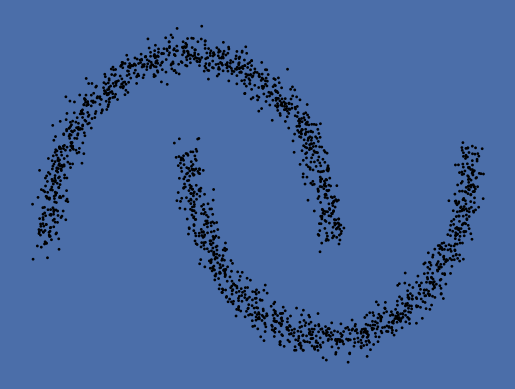

In [3]:
n_samples = X.shape[0]
Y = np.ones(n_samples)
fig, ax = plt.subplots(1, 1,facecolor='#4B6EA9')

plot_data(ax, X, Y)
plt.show()

In [4]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


# A simple GAN

We start with the simple GAN described in the course.

In [5]:
import torch.nn as nn

z_dim = 32
hidden_dim = 128

net_G = nn.Sequential(nn.Linear(z_dim,hidden_dim),
                     nn.ReLU(), nn.Linear(hidden_dim, 2))

net_D = nn.Sequential(nn.Linear(2,hidden_dim),
                     nn.ReLU(),
                     nn.Linear(hidden_dim,1),
                     nn.Sigmoid())

net_G = net_G.to(device)
net_D = net_D.to(device)

Training loop as described in the course, keeping the losses for the discriminator and the generator.

In [6]:
batch_size = 50
lr = 1e-4
nb_epochs = 500

optimizer_G = torch.optim.Adam(net_G.parameters(),lr=lr)
optimizer_D = torch.optim.Adam(net_D.parameters(),lr=lr)

loss_D_epoch = []
loss_G_epoch = []
for e in range(nb_epochs):
    np.random.shuffle(X)
    real_samples = torch.from_numpy(X).type(torch.FloatTensor)
    loss_G = 0
    loss_D = 0
    for t, real_batch in enumerate(real_samples.split(batch_size)):
            #improving D
        z = torch.empty(batch_size,z_dim).normal_().to(device)
        fake_batch = net_G(z)
        D_scores_on_real = net_D(real_batch.to(device))
        D_scores_on_fake = net_D(fake_batch)
            
        loss = -torch.mean(torch.log(1-D_scores_on_fake) + torch.log(D_scores_on_real))
        optimizer_D.zero_grad()
        loss.backward()
        optimizer_D.step()
        loss_D += loss.cpu().data.numpy()
                    
            # improving G
        z = torch.empty(batch_size,z_dim).normal_().to(device)
        fake_batch = net_G(z)
        D_scores_on_fake = net_D(fake_batch)
            
        loss = -torch.mean(torch.log(D_scores_on_fake))
        optimizer_G.zero_grad()
        loss.backward()
        optimizer_G.step()
        loss_G += loss.cpu().data.numpy()
           
    loss_D_epoch.append(loss_D)
    loss_G_epoch.append(loss_G)

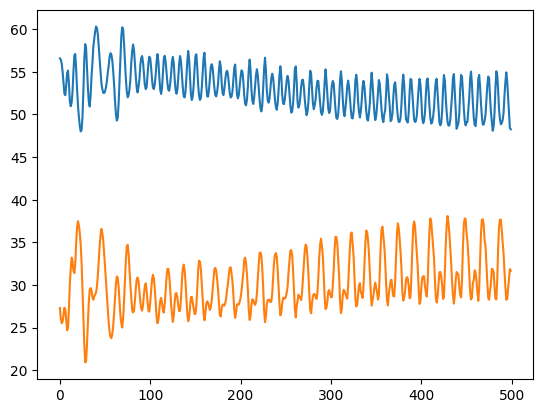

In [7]:
plt.plot(loss_D_epoch)
plt.plot(loss_G_epoch)

In [8]:
z = torch.empty(n_samples,z_dim).normal_().to(device)
fake_samples = net_G(z)
fake_data = fake_samples.cpu().data.numpy()

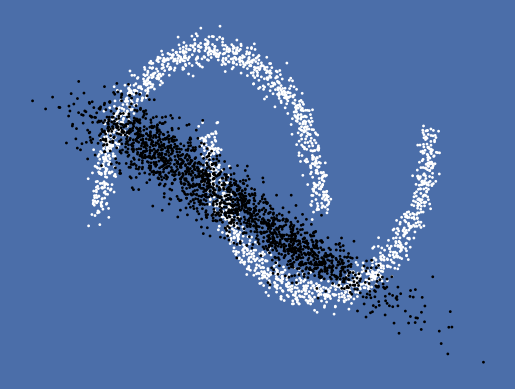

In [9]:
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
all_data = np.concatenate((X,fake_data),axis=0)
Y2 = np.concatenate((np.ones(n_samples),np.zeros(n_samples)))
plot_data(ax, all_data, Y2)
plt.show();

It looks like the GAN is oscillating. Try again with lr=1e-3

In [10]:
batch_size = 50
lr = 1e-3
nb_epochs = 500

optimizer_G = torch.optim.Adam(net_G.parameters(),lr=lr)
optimizer_D = torch.optim.Adam(net_D.parameters(),lr=lr)

loss_D_epoch = []
loss_G_epoch = []
for e in range(nb_epochs):
    np.random.shuffle(X)
    real_samples = torch.from_numpy(X).type(torch.FloatTensor)
    loss_G = 0
    loss_D = 0
    for t, real_batch in enumerate(real_samples.split(batch_size)):
            #improving D
        z = torch.empty(batch_size,z_dim).normal_().to(device)
        fake_batch = net_G(z)
        D_scores_on_real = net_D(real_batch.to(device))
        D_scores_on_fake = net_D(fake_batch)
            
        loss = -torch.mean(torch.log(1-D_scores_on_fake) + torch.log(D_scores_on_real))
        optimizer_D.zero_grad()
        loss.backward()
        optimizer_D.step()
        loss_D += loss.cpu().data.numpy()
                    
            # improving G
        z = torch.empty(batch_size,z_dim).normal_().to(device)
        fake_batch = net_G(z)
        D_scores_on_fake = net_D(fake_batch)
            
        loss = -torch.mean(torch.log(D_scores_on_fake))
        optimizer_G.zero_grad()
        loss.backward()
        optimizer_G.step()
        loss_G += loss.cpu().data.numpy()
           
    loss_D_epoch.append(loss_D)
    loss_G_epoch.append(loss_G)

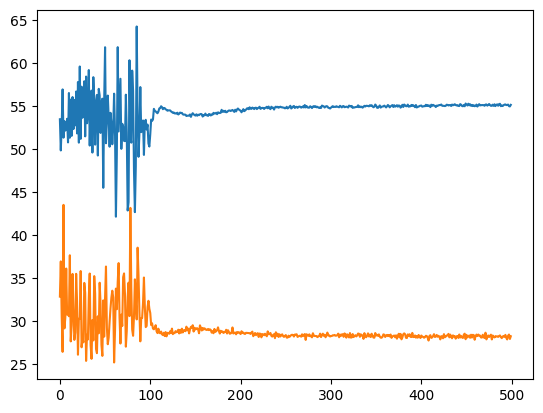

In [11]:
plt.plot(loss_D_epoch)
plt.plot(loss_G_epoch)

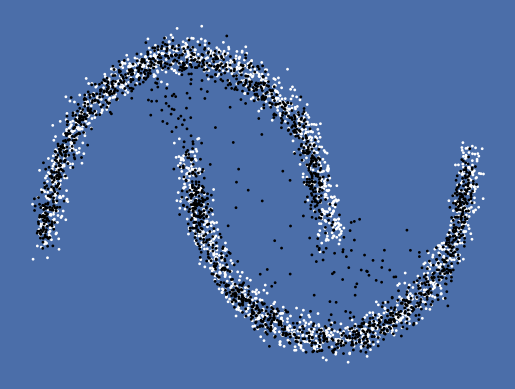

In [12]:
z = torch.empty(n_samples,z_dim).normal_().to(device)
fake_samples = net_G(z)
fake_data = fake_samples.cpu().data.numpy()
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
all_data = np.concatenate((X,fake_data),axis=0)
Y2 = np.concatenate((np.ones(n_samples),np.zeros(n_samples)))
plot_data(ax, all_data, Y2)
plt.show();

We can generate more points:

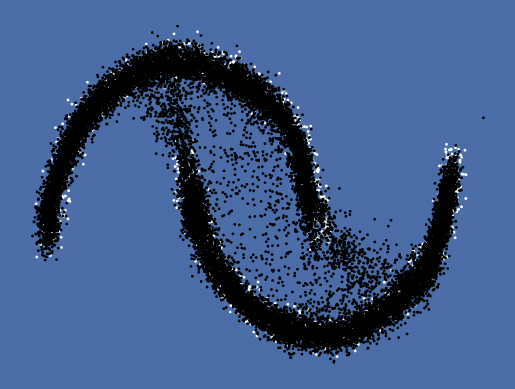

In [13]:
z = torch.empty(10*n_samples,z_dim).normal_().to(device)
fake_samples = net_G(z)
fake_data = fake_samples.cpu().data.numpy()
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
all_data = np.concatenate((X,fake_data),axis=0)
Y2 = np.concatenate((np.ones(n_samples),np.zeros(10*n_samples)))
plot_data(ax, all_data, Y2)
plt.show();

# Conditional GAN

We are now implementing a [conditional GAN](https://arxiv.org/abs/1411.1784).

We start by separating the two half moons in two clusters as follows:

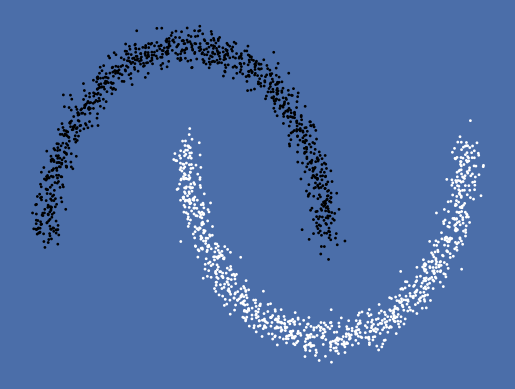

In [14]:
X, Y = make_moons(n_samples=2000, noise=0.05)
n_samples = X.shape[0]
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
plot_data(ax, X, Y)
plt.show()

The task is now given a white or black label to generate points in the corresponding cluster.

Both the generator and the discriminator take in addition a one hot encoding of the label. The generator will now generate fake points corresponding to the input label. The discriminator, given a pair of sample and label should detect if this is a fake or a real pair.

In [15]:
z_dim = 32
hidden_dim = 128
label_dim = 2


class generator(nn.Module):
    def __init__(self,z_dim = z_dim, label_dim=label_dim,hidden_dim =hidden_dim):
        super(generator,self).__init__()
        self.net = nn.Sequential(nn.Linear(z_dim+label_dim,hidden_dim),
                     nn.ReLU(), nn.Linear(hidden_dim, 2))
        
    def forward(self, input, label_onehot):
        x = torch.cat([input, label_onehot], 1)
        return self.net(x)
    
class discriminator(nn.Module):
    def __init__(self,z_dim = z_dim, label_dim=label_dim,hidden_dim =hidden_dim):
        super(discriminator,self).__init__()
        self.net =  nn.Sequential(nn.Linear(2+label_dim,hidden_dim),
                     nn.ReLU(),
                     nn.Linear(hidden_dim,1),
                     nn.Sigmoid())
        
    def forward(self, input, label_onehot):
        x = torch.cat([input, label_onehot], 1)
        return self.net(x)
        

net_CG = generator().to(device)
net_CD = discriminator().to(device)

You need to code the training loop:

In [16]:
batch_size = 50
lr = 1e-3
nb_epochs = 1000

optimizer_CG = torch.optim.Adam(net_CG.parameters(),lr=lr)
optimizer_CD = torch.optim.Adam(net_CD.parameters(),lr=lr)
loss_D_epoch = []
loss_G_epoch = []
for e in range(nb_epochs):
    rperm = np.random.permutation(X.shape[0]);
    np.take(X,rperm,axis=0,out=X);
    np.take(Y,rperm,axis=0,out=Y);
    real_samples = torch.from_numpy(X).type(torch.FloatTensor)
    real_labels = torch.from_numpy(Y).type(torch.LongTensor)
    loss_G = 0
    loss_D = 0
    for real_batch, real_batch_label in zip(real_samples.split(batch_size),real_labels.split(batch_size)):
            #improving D
        z = torch.empty(batch_size,z_dim).normal_().to(device)
        #
        # your code here
        # hint: https://discuss.pytorch.org/t/convert-int-into-one-hot-format/507/4
        label = torch.LongTensor(batch_size,1).random_() % label_dim
        label_onehot = torch.FloatTensor(batch_size, label_dim).zero_()
        label_onehot = label_onehot.scatter_(1, label, 1).to(device)
        fake_batch = net_CG(z, label_onehot)
        D_scores_on_fake = net_CD(fake_batch, label_onehot)
        label_onehot = torch.FloatTensor(batch_size, label_dim).zero_()
        label_onehot = label_onehot.scatter_(1, real_batch_label.unsqueeze(1), 1).to(device)
        D_scores_on_real = net_CD(real_batch.to(device),label_onehot)
        #
                
        loss = -torch.mean(torch.log(1-D_scores_on_fake) + torch.log(D_scores_on_real))
        optimizer_CD.zero_grad()
        loss.backward()
        optimizer_CD.step()
        loss_D += loss.cpu().data.numpy()
            
            # improving G
        z = torch.empty(batch_size,z_dim).normal_().to(device)
        #
        # your code here
        label = torch.LongTensor(batch_size,1).random_() % label_dim
        label_onehot = torch.FloatTensor(batch_size, label_dim).zero_()
        label_onehot = label_onehot.scatter_(1, label, 1).to(device)
        fake_batch = net_CG(z, label_onehot)
        D_scores_on_fake = net_CD(fake_batch, label_onehot)
        #
                    
        loss = -torch.mean(torch.log(D_scores_on_fake))
        optimizer_CG.zero_grad()
        loss.backward()
        optimizer_CG.step()
        loss_G += loss.cpu().data.numpy()
                    
    loss_D_epoch.append(loss_D)
    loss_G_epoch.append(loss_G)

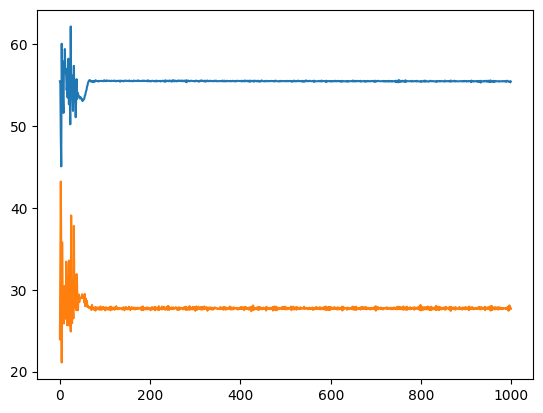

In [17]:
plt.plot(loss_D_epoch)
plt.plot(loss_G_epoch)

In [18]:
z = torch.empty(n_samples,z_dim).normal_().to(device)
label = torch.LongTensor(n_samples,1).random_() % label_dim
label_onehot = torch.FloatTensor(n_samples, label_dim).zero_()
label_onehot = label_onehot.scatter_(1, label, 1).to(device)
fake_samples = net_CG(z, label_onehot)
fake_data = fake_samples.cpu().data.numpy()

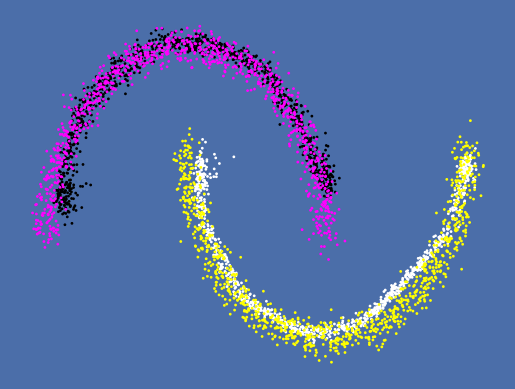

In [19]:
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
plot_data(ax, fake_data, label.squeeze().numpy())
plot_data(ax, X, Y, 'spring')
plt.show()

# Info GAN

Here we implement a simplified version of the algorithm presented in the [InfoGAN paper](https://arxiv.org/abs/1606.03657).

This time, you do not have access to the labels but you know there are two classes. The idea is then to provide as in the conditional GAN a random label to the generator but in opposition to the conditional GAN, the discriminator cannot take as input the label (since they are not provided to us) but instead the discriminator will predict a label and this prediction can be trained on fake samples only!

In [20]:
import torch.nn.functional as F

z_dim = 32
hidden_dim = 128
label_dim = 2


class Igenerator(nn.Module):
    def __init__(self,z_dim = z_dim, label_dim=label_dim,hidden_dim =hidden_dim):
        super(Igenerator,self).__init__()
        self.net = nn.Sequential(nn.Linear(z_dim+label_dim,hidden_dim),
                     nn.ReLU(), nn.Linear(hidden_dim, 2))
        
    def forward(self, input, label_onehot):
        x = torch.cat([input, label_onehot], 1)
        return self.net(x)
    
class Idiscriminator(nn.Module):
    def __init__(self,z_dim = z_dim, label_dim=label_dim,hidden_dim =hidden_dim):
        super(Idiscriminator,self).__init__()
        self.fc1 = nn.Linear(2,hidden_dim)
        self.fc2 = nn.Linear(hidden_dim,1)
        self.fc3 = nn.Linear(hidden_dim,1)
        
    def forward(self, input):
        x = F.relu(self.fc1(input))
        output = torch.sigmoid(self.fc2(x))
        est_label = torch.sigmoid(self.fc3(x)) 
        return output, est_label
        

net_IG = Igenerator().to(device)
net_ID = Idiscriminator().to(device)

Here, we add `loss_fn` which is the `BCELoss` to be used for the binary classification task of the discriminator on the fake samples.

In [21]:
batch_size = 50
lr = 1e-3
nb_epochs = 1000
loss_fn = nn.BCELoss()

In [22]:
optimizer_IG = torch.optim.Adam(net_IG.parameters(),lr=lr)
optimizer_ID = torch.optim.Adam(net_ID.parameters(),lr=lr)
loss_D_epoch = []
loss_G_epoch = []
for e in range(nb_epochs):
    
    rperm = np.random.permutation(X.shape[0]);
    np.take(X,rperm,axis=0,out=X);
    #np.take(Y,rperm,axis=0,out=Y);
    real_samples = torch.from_numpy(X).type(torch.FloatTensor)
    #real_labels = torch.from_numpy(Y).type(torch.LongTensor)
    loss_G = 0
    loss_D = 0
    for real_batch in real_samples.split(batch_size):
            #improving D
        z = torch.empty(batch_size,z_dim).normal_().to(device)
        #
        # your code here
        label = torch.LongTensor(batch_size,1).random_() % label_dim
        label_onehot = torch.FloatTensor(batch_size, label_dim).zero_()
        label_onehot = label_onehot.scatter_(1, label, 1).to(device)
        fake_batch = net_IG(z, label_onehot)
        D_scores_on_fake, est_label_on_fake = net_ID(fake_batch)
        D_scores_on_real, est_label_on_real = net_ID(real_batch.to(device))
        lossD = -torch.mean(torch.log(1-D_scores_on_fake) + torch.log(D_scores_on_real))
        lossD.add_(loss_fn(est_label_on_fake,label.type(torch.FloatTensor).to(device)))
        optimizer_ID.zero_grad()
        lossD.backward()
        optimizer_ID.step()
        loss_D += lossD.cpu().data.numpy()
        #
        
            
            # improving G
        z = torch.empty(batch_size,z_dim).normal_().to(device)
        #
        # your code here
        label = torch.LongTensor(batch_size,1).random_() % label_dim
        label_onehot = torch.FloatTensor(batch_size, label_dim).zero_()
        label_onehot = label_onehot.scatter_(1, label, 1).to(device)
        fake_batch = net_IG(z, label_onehot)
        D_scores_on_fake, est_label_on_fake = net_ID(fake_batch)
        lossG = -torch.mean(torch.log(D_scores_on_fake))
        lossG.add_(loss_fn(est_label_on_fake,label.type(torch.FloatTensor).to(device)))
        optimizer_IG.zero_grad()
        lossG.backward()
        optimizer_IG.step()
        loss_G += lossG.cpu().data.numpy()
        #
               
            
    loss_D_epoch.append(loss_D)
    loss_G_epoch.append(loss_G)

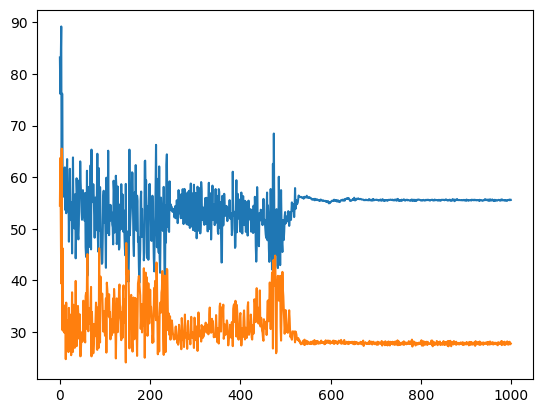

In [23]:
plt.plot(loss_D_epoch)
plt.plot(loss_G_epoch)

In [24]:
z = torch.empty(n_samples,z_dim).normal_().to(device)
label = torch.LongTensor(n_samples,1).random_() % label_dim
label_onehot = torch.FloatTensor(n_samples, label_dim).zero_()
label_onehot = label_onehot.scatter_(1, label, 1).to(device)
fake_samples = net_IG(z, label_onehot)
fake_data = fake_samples.cpu().data.numpy()

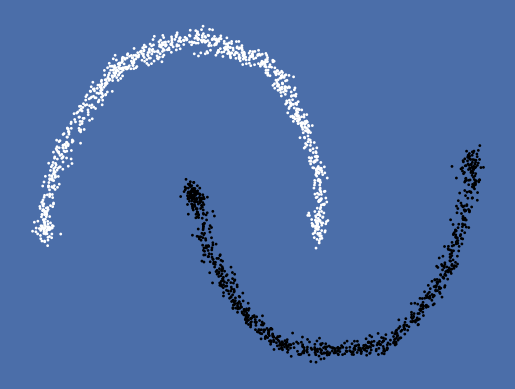

In [25]:
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
plot_data(ax, fake_data, label.squeeze().numpy())
plt.show()

Note that sometimes the InfoGAN is not converging to the 'desired' solution:

![](https://raw.githubusercontent.com/dataflowr/slides/master/images/module10/IGAN_failed.png)

or

![](https://raw.githubusercontent.com/dataflowr/slides/master/images/module10/IGAN_failed2.png)

[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)